<a href="https://colab.research.google.com/github/Mike-R0d/GDP-Nowcasting-Using-Electricity-Consumption/blob/main/Nowcasting_GDP_Using_Electricity_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Box-Jenkins Methodology**
---

## **1. Identification**
- **Objective**: Determine if the series is stationary and select the initial order of the ARIMA model \((p, d, q)\).
- **Steps**:
  - Plot the time series to identify patterns such as trends or seasonality.
  - Perform stationarity tests (e.g., Augmented Dickey-Fuller test) to verify if the series is stationary.
  - Apply transformations if necessary (differencing, logarithms, etc.) to achieve stationarity.
  - Examine the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine initial values for \(p\) and \(q\).

---

## **2. Estimation**
- **Objective**: Estimate the parameters of the selected ARIMA model.
- **Steps**:
  - Test different combinations of parameters \((p, d, q)\).
  - Fit the model using methods such as Maximum Likelihood Estimation.
  - Select the model that minimizes information criteria, such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion).

---

## **3. Diagnostic Checking**
- **Objective**: Validate the fitted model and ensure it meets the assumptions.
- **Steps**:
  - Analyze the residuals of the model to confirm they are white noise (independent and normally distributed).
  - Check for significant autocorrelation in the residuals (using tests like Ljung-Box).
  - If the model is inadequate, return to the **Identification** stage or adjust the parameters.

---

## **4. Forecasting**
- **Objective**: Use the fitted model to make future predictions.
- **Steps**:
  - Generate forecasts based on the final model.
  - Compute confidence intervals for the predictions.
  - Compare predictions to actual data (if available) to evaluate model accuracy.

---


**IV. Time Series Analysis Variables:**

*   `y`: Represents the dependent variable in the analysis. In this case,  GDP growth rates.
*   `x`:  The exogenous variable, electricity growth rates, which is used to predict GDP growth.
*    `t`: Represents the time index of data (dates).
*   `model`:  A statistical model object (e.g., OLS or ARIMA models)
*   `predictions`:  Predicted values from the fitted model.
*   `residuals`:  The difference between observed (`y`) and predicted values (`predictions`).
*   `result_elec`, `result_gdp`: Results of the Augmented Dickey-Fuller (ADF) test for stationarity of electricity growth and GDP growth, respectively.
*   `p`, `d`, `q`: Order parameters for the ARIMA model.
*   `best_aic`, `best_bic`, `best_order`, `best_model`: Used to keep track of the best model based on criteria like AIC and BIC, optimizing the model.
* `bg_test`, `bg_test_arima`: Results of the Breusch-Godfrey test for autocorrelation in the residuals.

In [252]:
import requests
import urllib.request
import time
from urllib3.exceptions import InsecureRequestWarning
import pandas as pd
import datetime
from datetime import date

# Sources

https://www.bcrp.gob.pe/docs/Publicaciones/Documentos-de-Trabajo/2018/documento-de-trabajo-010-2018.pdf
https://app.electricitymaps.com/zone/PE/72h/hourly
https://estadisticas.bcrp.gob.pe/estadisticas/series/trimestrales/resultados/PN02526AQ/html
https://www.coes.org.pe/Portal/portalinformacion/demanda?fechaInicial=01/01/2023&fechaFinal=01/01/2024
https://app.electricitymaps.com/zone/PE/72h/hourly

## Electricity Demand


---



In [253]:
import requests
import pandas as pd
import plotly.graph_objects as go
from IPython.display import Image

def fetch_energy_data():
    # Create a requests session
    sess = requests.Session()

    # Construct the URL without dates
    url = "https://www.coes.org.pe/Portal/portalinformacion/demanda"

    # Make the request
    r = sess.post(url)

    # Debugging: print the raw response
    # print("Raw Response:", r.text[:500])  # Print the first 500 characters of the response for debugging

    # Ensure valid JSON response
    try:
        datos = r.json()
        data = datos.get('Data', [])

        # Debugging: print the content of `data`
        # print("Data Content:", data[:5])  # Print the first 5 entries for debugging
    except Exception as e:
        raise ValueError(f"Failed to parse JSON from the response. Error: {e}, Response: {r.text[:500]}")

    # Create DataFrame
    df = pd.DataFrame(data)
    df = df.rename(columns={
        'Fecha': 'Date',
        'ValorEjecutado': 'Executed',
        'ValorProgramacionDiaria': 'Daily Prog.',
        'ValorProgramacionSemanal': 'Weekly Prog.'
    })

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])  # Drop rows with invalid dates
    return df

# Fetch the data
df = fetch_energy_data()

In [254]:
# Add traces for each data series
fig = go.Figure()  # Initialize the figure
fig.add_trace(go.Scatter(x=df['Date'], y=df['Executed'], mode='lines', name='Executed', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Daily Prog.'], mode='lines', name='Daily Prog.', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Weekly Prog.'], mode='lines', name='Weekly Prog.', line=dict(color='red', dash='dot')))

# Update layout with plotly_dark template
fig.update_layout(
    title="Electricity Demand",
    xaxis_title="Date",
    yaxis_title="MW",
    legend_title="Legend",
    template="plotly_white",  # Use plotly_white template
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(l=40, r=40, t=40, b=40)
)

## Electricity Demand

##Identification
---

###Pre-processing


In [255]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

pd.options.display.float_format = '{:,.2f}'.format
file_path1 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_economic_activity.xlsx' # Replace with your actual file path
file_path2 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_electricity.xlsx' # Replace with your actual file path

pd.options.display.float_format = '{:,.2f}'.format
df_electricity = pd.read_excel(file_path2)
df_electricity.set_index('Date',inplace=True)
df_electricity = df_electricity[['Ejecutado']]
df_electricity.rename(columns = {'Ejecutado':'Electricity'}, inplace = True)

df_elect = df_electricity.copy()
df_elect = df_elect.resample('Q').sum()
df_elect = df_elect.pct_change(4).shift(0)
df_elect = df_elect.ffill()*100

df_gdp = pd.read_excel(file_path1)
df_gdp.set_index('Date',inplace=True)
df_gdp = df_gdp[['PN02526AQ']]

df_merge = pd.merge(df_elect,df_gdp,left_on='Date',right_on='Date')
df_merge.rename(columns = {'Electricity':'Elect_Growth'}, inplace = True)
df_merge.rename(columns = {'PN02526AQ':'GDP'}, inplace = True)
df_merge['Diff'] = df_merge['Elect_Growth'] - df_merge['GDP']
df_merge = df_merge.loc[df_merge.index >= '2007-09-01']
df_merge = df_merge.loc[df_merge.index <= '2024-09-30']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=df_merge.index, y=df_merge['GDP'], name="GDP Growth rate"), secondary_y=True)
fig.add_trace(go.Scatter(x=df_merge.index, y=df_merge['Elect_Growth'], name="Electricity growth rate"), secondary_y=True)
fig.add_bar(x=df_merge.index, y=df_merge['Diff'], name="Difference (%)", secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")

# # Set x-axis title
# fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Difference</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>GDP and Electricity growth rate</b> (%)", secondary_y=True)

# Update layout for the legend to be at the bottom
fig.update_layout(
    template='simple_white',
    title="Electric demand & Peruvian GDP growth rate",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()


###Stationarity test


---



In [257]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_merge is already defined and filtered

# Prepare the data
y = df_merge['GDP'].values
x = df_merge['Elect_Growth'].values

# Perform the ADF test on electricity growth (exogenous)
result_elec = adfuller(x)

# Perform the ADF test on GDP growth (endogenous)
result_gdp = adfuller(y)

# Function to extract ADF test results into a dictionary
def extract_adf_results(result, variable_name):
    adf_stat, p_value, used_lag, n_obs, crit_values, ic_best = result
    return {
        'Variable': variable_name,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Number of lags used': used_lag,
        'Number of observations': n_obs,
        'Critical Value (1%)': crit_values['1%'],
        'Critical Value (5%)': crit_values['5%'],
        'Critical Value (10%)': crit_values['10%'],
        'Information Criterion': ic_best,
        'Conclusion (5%)': 'Stationary' if p_value < 0.05 else 'Non-stationary'
    }

# Extract results
results = [
    extract_adf_results(result_elec, 'Electricity Growth'),
    extract_adf_results(result_gdp, 'GDP Growth')
]

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
display(df_results)


,Variable,ADF Statistic,p-value,Number of lags used,Number of observations,Critical Value (1%),Critical Value (5%),Critical Value (10%),Information Criterion,Conclusion (5%)
0,Electricity Growth,-3.80,0.00,4,64,-3.54,-2.91,-2.59,351.14,Stationary
1,GDP Growth,-5.71,0.00,3,65,-3.54,-2.91,-2.59,380.75,Stationary


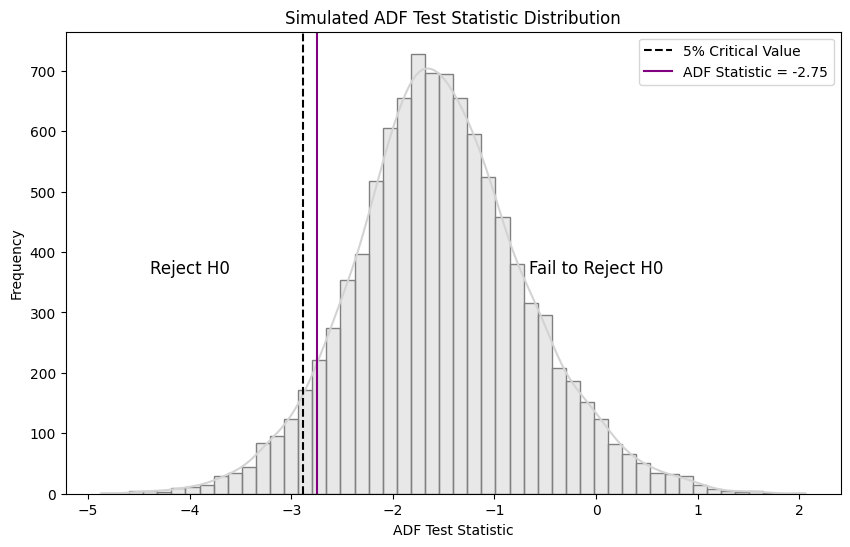

In [258]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# Number of simulations
num_simulations = 10000
sample_size = 100
adf_stats = []

# Simulate random walk data and perform ADF test
for _ in range(num_simulations):
    random_walk = np.random.randn(sample_size).cumsum()
    result = adfuller(random_walk, maxlag=0, regression='c')
    adf_stats.append(result[0])

# Convert to DataFrame
df_adf_stats = pd.DataFrame(adf_stats, columns=['ADF Statistic'])

# Calculate empirical critical values
critical_values = {
    '5%': np.percentile(df_adf_stats['ADF Statistic'], 5),
}

# Define the ADF statistic to visualize
adf_statistic_to_visualize = -2.75

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_adf_stats['ADF Statistic'], bins=50, kde=True, color='lightgrey', edgecolor='grey')
plt.axvline(critical_values['5%'], color='black', linestyle='--', label='5% Critical Value')
plt.axvline(adf_statistic_to_visualize, color='purple', linestyle='-', label=f'ADF Statistic = {adf_statistic_to_visualize}')

# Add text annotations for the zones
max_y = df_adf_stats['ADF Statistic'].value_counts(bins=50).max()
plt.text(-4, max_y / 2, 'Reject H0', horizontalalignment='center', color='black', fontsize=12)
plt.text(0, max_y / 2, 'Fail to Reject H0', horizontalalignment='center', color='black', fontsize=12)

plt.title('Simulated ADF Test Statistic Distribution')
plt.xlabel('ADF Test Statistic')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


##Estimation
---

###Preliminary model
---




In [259]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

pd.options.display.float_format = '{:,.2f}'.format
file_path1 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_economic_activity.xlsx' # Replace with your actual file path
file_path2 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_electricity.xlsx' # Replace with your actual file path

pd.options.display.float_format = '{:,.2f}'.format
df_electricity = pd.read_excel(file_path2)
df_electricity.set_index('Date',inplace=True)
df_electricity = df_electricity[['Ejecutado']]
df_electricity.rename(columns = {'Ejecutado':'Electricity'}, inplace = True)

df_elect = df_electricity.copy()
df_elect = df_elect.resample('Q').sum()
df_elect = df_elect.pct_change(4).shift(0)
df_elect = df_elect.ffill()*100

df_gdp = pd.read_excel(file_path1)
df_gdp.set_index('Date',inplace=True)
df_gdp = df_gdp[['PN02526AQ']]

df_merge = pd.merge(df_elect,df_gdp,left_on='Date',right_on='Date')
df_merge.rename(columns = {'Electricity':'Elect_Growth'}, inplace = True)
df_merge.rename(columns = {'PN02526AQ':'GDP'}, inplace = True)
df_merge['Diff'] = df_merge['Elect_Growth'] - df_merge['GDP']
df_merge = df_merge.loc[df_merge.index >= '2007-09-01']
df_merge = df_merge.loc[df_merge.index <= '2024-09-30']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [260]:
import plotly.graph_objects as go
import pandas as pd
import statsmodels.api as sm

# Assuming df_merge is already defined and filtered
# Prepare the data
t = df_merge.index
y = df_merge['GDP'].values
x = df_merge['Elect_Growth'].values
# x = sm.add_constant(x)

# Fit the OLS model
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
summary = model.summary()
print(summary)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              427.2
Date:                Fri, 24 Jan 2025   Prob (F-statistic):                    5.00e-31
Time:                        21:56:53   Log-Likelihood:                         -174.34
No. Observations:                  69   AIC:                                      350.7
Df Residuals:                      68   BIC:                                      352.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [261]:
t = df_merge.index
y = df_merge['GDP'].values
x = df_merge['Elect_Growth'].values
residuals = y - predictions

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Date': t,
    'GDP Growth': y,
    'Estimated GDP Growth': predictions,
    'Residuals': residuals
})
df_plot.set_index('Date', inplace=True)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['GDP Growth'], name="GDP Growth"), secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['Estimated GDP Growth'], name="Estimated GDP Growth"), secondary_y=True)
fig.add_bar(x=df_plot.index, y=df_plot['Residuals'], name="Residuals", secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Residuals</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>GDP growth and GDP growth estimated</b> (%)", secondary_y=True)

# Update layout for the legend to be at the bottom
fig.update_layout(
    template='simple_white',
    title="Nowcasting: Peruvian GDP growth rate",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()

In [262]:
import statsmodels.api as sm

# Assuming df_merge and the OLS model are already defined as in the previous code

# Fit the OLS model
model = sm.OLS(y, x).fit()

# Perform the Breusch-Godfrey test for autocorrelation
bg_test = sm.stats.diagnostic.acorr_breusch_godfrey(model, nlags=1) # nlags specifies the number of lags to test


# Print the test results
print("Breusch-Godfrey Test for Autocorrelation:")
print("LM Statistic:", bg_test[0])
print("p-value:", bg_test[1])
print("Degrees of Freedom:", bg_test[2])
print("Expected Value:", bg_test[3])


# Interpret the results
alpha = 0.05
if bg_test[1] < alpha:
  print("\nReject the null hypothesis: There is evidence of autocorrelation in the residuals.")
else:
  print("\nFail to reject the null hypothesis: There is no evidence of autocorrelation in the residuals.")

Breusch-Godfrey Test for Autocorrelation:
LM Statistic: 36.26054084954948
p-value: 1.7262381050523032e-09
Degrees of Freedom: 54.397995453524764
Expected Value: 3.468293881948384e-10

Reject the null hypothesis: There is evidence of autocorrelation in the residuals.


###Diagnostic Checking

##Model Optimizing
---

In [263]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Prepare the data
y = df_merge['GDP'].values  # Dependent variable (time series)
x = df_merge['Elect_Growth'].values  # Exogenous variable

# Range for p, d, q values
p_range = range(0, 3)  # Adjust the range as needed
d_range = range(0, 2)
q_range = range(0, 3)

# Store results
best_aic = float("inf")
best_bic = float("inf")
best_order = None
best_model = None

# Loop to test different combinations of (p, d, q)
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Fit the ARIMA model
                model = ARIMA(y, order=(p, d, q), exog=x, trend='n')  # Without constant
                model_fit = model.fit()

                # Compare AIC and BIC
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_order = (p, d, q)
                    best_model = model_fit

            except Exception as e:
                # Ignore combinations that do not converge
                continue

# Best model results
print(f"Best ARIMA order (p, d, q): {best_order}")
print(f"Best AIC: {best_aic}")
print(f"Best BIC: {best_bic}")
print(best_model.summary())


Best ARIMA order (p, d, q): (2, 1, 1)
Best AIC: 281.29728061824693
Best BIC: 292.39481914412744
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -135.649
Date:                Fri, 24 Jan 2025   AIC                            281.297
Time:                        21:56:57   BIC                            292.395
Sample:                             0   HQIC                           285.694
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1949      0.028     43.258      0.000       1.141       1.249
ar.L1          0.9277      0.148   

In [264]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Prepare the data (already stationary as growth rates)
y = df_merge['GDP'].values  # Dependent variable (time series, growth rates)
x = df_merge['Elect_Growth'].values  # Exogenous variable (growth rates)

# Range for p and q values (without differencing d=0)
p_range = range(0, 3)
q_range = range(0, 3)

# Store results
best_aic = float("inf")
best_bic = float("inf")
best_order = None
best_model = None

# Loop to test different combinations of (p, q)
for p in p_range:
    for q in q_range:
        try:
            # Fit ARIMA model without differencing (d=0)
            model = ARIMA(y, order=(p, 0, q), exog=x, trend='n')  # Without constant
            model_fit = model.fit()

            # Compare AIC and BIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 0, q)
                best_model = model_fit

        except Exception as e:
            # Skip combinations that do not converge
            continue

# Best model results
print(f"Best ARIMA order (p, 0, q): {best_order}")
print(f"Best AIC: {best_aic}")
print(f"Best BIC: {best_bic}")
print(best_model.summary())


Best ARIMA order (p, 0, q): (2, 0, 0)
Best AIC: 286.34662476902093
Best BIC: 295.28305078741
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -139.173
Date:                Fri, 24 Jan 2025   AIC                            286.347
Time:                        21:57:00   BIC                            295.283
Sample:                             0   HQIC                           289.892
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1877      0.025     46.920      0.000       1.138       1.237
ar.L1          0.9841      0.124      

### Pre processing

In [265]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

pd.options.display.float_format = '{:,.2f}'.format
file_path1 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_economic_activity.xlsx' # Replace with your actual file path
file_path2 = '/content/drive/My Drive/Portfolio/GPD_Electrical_Consuption/DB_electricity.xlsx' # Replace with your actual file path

pd.options.display.float_format = '{:,.2f}'.format
df_electricity = pd.read_excel(file_path2)
df_electricity.set_index('Date',inplace=True)
df_electricity = df_electricity[['Ejecutado']]
df_electricity.rename(columns = {'Ejecutado':'Electricity'}, inplace = True)

df_elect = df_electricity.copy()
df_elect = df_elect.resample('Q').sum()
df_elect = df_elect.pct_change(4).shift(0)
df_elect = df_elect.ffill()*100

df_gdp = pd.read_excel(file_path1)
df_gdp.set_index('Date',inplace=True)
df_gdp = df_gdp[['PN02526AQ']]

df_merge = pd.merge(df_elect,df_gdp,left_on='Date',right_on='Date')
df_merge.rename(columns = {'Electricity':'Elect_Growth'}, inplace = True)
df_merge.rename(columns = {'PN02526AQ':'GDP'}, inplace = True)
df_merge['Diff'] = df_merge['Elect_Growth'] - df_merge['GDP']
df_merge = df_merge.loc[df_merge.index >= '2007-09-01']
df_merge = df_merge.loc[df_merge.index <= '2024-09-30']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Final Model
---

In [266]:
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from plotly.subplots import make_subplots

t = df_merge.index
y = df_merge['GDP'].values
x = df_merge['Elect_Growth'].values

order = (2, 0, 0)
model = ARIMA(y, order=order, exog=x, trend='n')

model_fit = model.fit()

predictions = model_fit.predict(start=0, end=len(y)-1, exog=x, dynamic=False)
residuals = y - predictions

summary = model_fit.summary()
print(summary)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -139.173
Date:                Fri, 24 Jan 2025   AIC                            286.347
Time:                        21:57:31   BIC                            295.283
Sample:                             0   HQIC                           289.892
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1877      0.025     46.920      0.000       1.138       1.237
ar.L1          0.9841      0.124      7.942      0.000       0.741       1.227
ar.L2         -0.1841      0.150     -1.229      0.2

### Diagram

In [267]:
bg_test_arima = sm.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=1)

# Print the test results for the ARIMA model
print("\nBreusch-Godfrey Test for Autocorrelation (ARIMA Model):")
print("LM Statistic:", bg_test_arima[0])
print("p-value:", bg_test_arima[1])
print("Degrees of Freedom:", bg_test_arima[2])
print("Expected Value:", bg_test_arima[3])

# Interpret the results for the ARIMA model
alpha = 0.05
if bg_test_arima[1] < alpha:
    print("\nReject the null hypothesis: There is evidence of autocorrelation in the ARIMA model residuals.")
else:
    print("\nFail to reject the null hypothesis: There is no evidence of autocorrelation in the ARIMA model residuals.")


Breusch-Godfrey Test for Autocorrelation (ARIMA Model):
LM Statistic: 0.23007396170761507
p-value: 0.631468992426986
Degrees of Freedom: 0.1489334288998848
Expected Value: 0.7007979075737234

Fail to reject the null hypothesis: There is no evidence of autocorrelation in the ARIMA model residuals.


In [270]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['GDP Growth'], name="GDP Growth"), secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['Estimated GDP Growth'], name="Estimated GDP Growth"), secondary_y=True)
fig.add_bar(x=df_plot.index, y=df_plot['Residuals'], name="Residuals", secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")

# # Set x-axis title
# fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Residuals</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>GDP growth and GDP growth estimated</b> (%)", secondary_y=True)

# Update layout for the legend to be at the bottom
fig.update_layout(
    template='simple_white',
    title="Nowcasting: Peruvian GDP growth rate",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()
plt.show()


### Prediction



In [269]:
import numpy as np

# Function to calculate Theil's U
def theil_u(actual, predicted):
    numerator = np.sqrt(np.mean((actual - predicted) ** 2))
    denominator = np.sqrt(np.mean(actual ** 2)) + np.sqrt(np.mean(predicted ** 2))
    return numerator / denominator

# Calculate known predictions
predictions = best_model.predict(start=0, end=len(y) - 1, exog=x, dynamic=False)

# Calculate Theil's U
u_theil = theil_u(y, predictions)
print(f"Theil's U: {u_theil:.4f}")

# Interpretation
if u_theil < 1:
    print("The model predicts better than the naive model.")
elif u_theil == 1:
    print("The model is as good as the naive model.")
else:
    print("The model is worse than the naive model.")


Theil's U: 0.1102
The model predicts better than the naive model.


# References

- **Bok, B., Caratelli, D., Giannone, D., Sbordone, A., & Tambalotti, A. (2018).**  
  *Macroeconomic Nowcasting and Forecasting with Big Data.*  
  *Annual Review Of Economics,* 10(1), 615-643.  
  [https://doi.org/10.1146/annurev-economics-080217-053214](https://doi.org/10.1146/annurev-economics-080217-053214)

- **Bragoli, D. (2017).**  
  *Now-casting the Japanese economy.*  
  *International Journal Of Forecasting,* 33(2), 390-402.  
  [https://doi.org/10.1016/j.ijforecast.2016.11.004](https://doi.org/10.1016/j.ijforecast.2016.11.004)

- **Bragoli, D., & Modugno, M. (2017).**  
  *A now-casting model for Canada: Do U.S. variables matter?*  
  *International Journal Of Forecasting,* 33(4), 786-800.  
  [https://doi.org/10.1016/j.ijforecast.2017.03.002](https://doi.org/10.1016/j.ijforecast.2017.03.002)

- **Bragoli, D., Metelli, L., & Modugno, M. (2014).**  
  *The Importance of Updating: Evidence from a Brazilian Nowcasting Model.*  
  *SSRN Electronic Journal.*  
  [https://doi.org/10.2139/ssrn.2529168](https://doi.org/10.2139/ssrn.2529168)

- **Evans, M. (2005).**  
  *Where Are We Now? Real-Time Estimates of the Macro Economy.*  
  *SSRN Electronic Journal.*  
  [https://doi.org/10.2139/ssrn.646103](https://doi.org/10.2139/ssrn.646103)

- **Giannone, D., Reichlin, L., & Small, D. (2008).**  
  *Nowcasting: The real-time informational content of macroeconomic data.*  
  *Journal Of Monetary Economics,* 55(4), 665-676.  
  [https://doi.org/10.1016/j.jmoneco.2008.05.010](https://doi.org/10.1016/j.jmoneco.2008.05.010)

- **Raftery, A., Madigan, D., & Hoeting, J. (1997).**  
  *Bayesian Model Averaging for Linear Regression Models.*  
  *Journal Of The American Statistical Association,* 92(437), 179-191.  
  [https://doi.org/10.1080/01621459.1997.10473615](https://doi.org/10.1080/01621459.1997.10473615)

- **Scott, S., & Varian, H. (2014).**  
  *Predicting the present with Bayesian structural time series.*  
  *International Journal Of Mathematical Modelling And Numerical Optimisation,* 5(1/2), 4.  
  [https://doi.org/10.1504/ijmmno.2014.059942](https://doi.org/10.1504/ijmmno.2014.059942)

- **Box, G. E. P., & Jenkins, G. M. (1976).**  
  *Time series analysis forecasting and control - rev. ed.*  
  Oakland, California, Holden-Day, 1976, 37(2), 238-242.
